In [1]:
# Does multi-profile deconvolution (Sharp and Birchall 2010, PASA, sec. 5.2)

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy
from astropy.io import fits
import copy
from scipy.sparse.linalg import lsmr

%matplotlib inline

In [2]:
# gaussian profile
def gaus1d(x_pass, mu_pass, sigma_pass):
    
    return (1./(sigma_pass*np.sqrt(2.*np.pi))) * np.exp(-0.5 * np.power((x_pass-mu_pass)/sigma_pass,2.) )

In [3]:
# Yoo-Jung's spectrum (not the broadband one)

hdul = fits.open('./data/stacked.fits')
test_data = hdul[0].data[0,:,:] # all 3 spectra
array_variance = hdul[0].data[1,:,:]

# ersatz bad pixel mask
y_center_1 = 104
y_center_2 = 160
y_center_3 = 179

# just 1 spectrum
test_data_1 = np.copy(test_data)
test_data_1[0:y_center_1-4,:] = 0
test_data_1[y_center_1+4:,:] = 0

# spectra 1 and 2
test_data_12 = np.copy(test_data)
test_data_12[0:y_center_1-4,:] = 0
test_data_12[y_center_1+4:y_center_2-4,:] = 0
test_data_12[y_center_2+4:,:] = 0

# spectra 1, 2, 3
test_data_123 = np.copy(test_data)
test_data_123[0:y_center_1-4,:] = 0
test_data_123[y_center_1+4:y_center_2-4,:] = 0
test_data_123[y_center_2+4:y_center_3-4,:] = 0
test_data_123[y_center_3+4:,:] = 0

In [12]:
# function to move spectra close together

def sim_close(y_first,y_second):
    '''
    y_first: y-value of first spectrum
    y_second: y-value of second spectrum
    angle_second: angle of second spec
    '''
    
    test_array = np.zeros(np.shape(test_data))
    
    test_array[y_first-4:y_first+4,:] += test_data_123[y_center_1-4:y_center_1+4,:]
    test_array[y_second-4:y_second+4,:] += test_data_123[y_center_2-4:y_center_2+4,:]
    
    return test_array

In [7]:
test = sim_close(y_first=10,y_second=15)

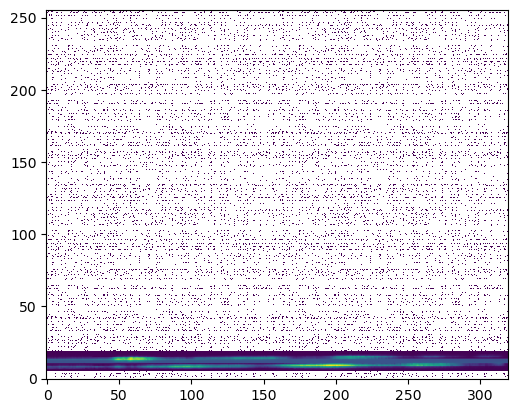

In [8]:
plt.imshow(test, origin='lower', norm='log')
plt.show()

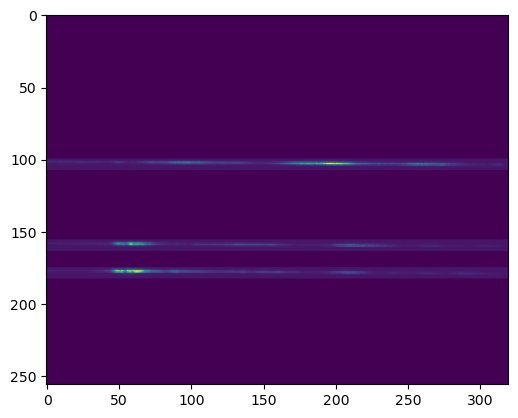

In [4]:
plt.imshow(test_data_123)
plt.savefig('junk.png')

In [5]:
# fit an extended Gaussian to the broadband image

#array_broadband = test_data[0,:,:]

# normalize ## ## necessary?
#test_data_1 = np.divide(test_data_1,np.nanmax(test_data_1))


In [9]:
# make the enclosing profile of the spectrum

def simple_profile(y_center, sigma_pass=1):
    # make simple 1D Gaussian profile in x-direction

    array_profile = np.zeros(np.shape(test_data))
    xgrid, ygrid = np.meshgrid(np.arange(0,np.shape(array_profile)[1]),np.arange(0,np.shape(array_profile)[0]))
    array_profile = gaus1d(x_pass = ygrid, mu_pass = y_center, sigma_pass=sigma_pass)

    # normalize it such that the marginalization in x (in (x,lambda) space) is 1
    # (with a perfect Gaussian profile in x this is redundant)
    array_profile = np.divide(array_profile,np.sum(array_profile, axis=0))
    
    return array_profile

In [10]:
# make profiles for all 3 spectra

simple_profile_1 = simple_profile(y_center=y_center_1,sigma_pass=3)
simple_profile_2 = simple_profile(y_center=y_center_2,sigma_pass=3)
simple_profile_3 = simple_profile(y_center=y_center_3,sigma_pass=3)

/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_3116/2167702469.py:40: RuntimeWarning: invalid value encountered in double_scalars
  c_11 += profile_first[i,col] * profile_first[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_3116/2167702469.py:42: RuntimeWarning: invalid value encountered in double_scalars
  c_12 += profile_first[i,col] * simple_profile_2[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_3116/2167702469.py:44: RuntimeWarning: invalid value encountered in double_scalars
  c_22 += profile_second[i,col] * profile_second[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_3116/2167702469.py:46: RuntimeWarning: invalid value encountered in double_scalars
  b_1 += D[i,col] * profile_first[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_3116/2167702469.py:48: RuntimeWarning: invalid value encountered in d

pixel_dist 9
pixel_dist 8
pixel_dist 7
pixel_dist 6
pixel_dist 5
pixel_dist 4
pixel_dist 3
pixel_dist 2
pixel_dist 1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


pixel_dist 0


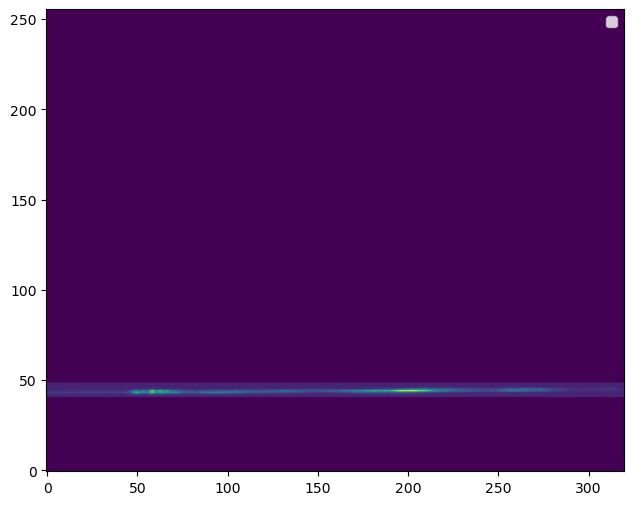

In [37]:
# for loop to extract spectra at different distances from each other

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6), sharey=False)

y_second_spacing_array = np.flip(np.arange(45,55)) #  flip to go from outside in

for y_second_this in y_second_spacing_array:
    
    y_first_fixed = 45
    
    test_readout = sim_close(y_first=y_first_fixed,y_second=y_second_this)
    
    profile_first = simple_profile(y_center=y_first_fixed, sigma_pass=1)
    profile_second = simple_profile(y_center=y_second_this, sigma_pass=1)
    
    ##### extraction
    # define test data
    D = test_readout

    # extent of detector in x-dir
    x_extent = np.shape(profile_first)[1]
    y_extent = np.shape(profile_first)[0]

    # initialize dict to hold flux for each spectrum
    eta = {'1':np.zeros(x_extent),'2':np.zeros(x_extent)}

    # loop over cols
    for col in range(0,x_extent): 

        # initialize
        c_11 = 0
        c_12 = 0
        c_22 = 0
        b_1 = 0
        b_2 = 0

        # loop over pixels
        for i in range(0,y_extent):

            c_11 += profile_first[i,col] * profile_first[i,col] / array_variance[i,col]

            c_12 += profile_first[i,col] * simple_profile_2[i,col] / array_variance[i,col]

            c_22 += profile_second[i,col] * profile_second[i,col] / array_variance[i,col]

            b_1 += D[i,col] * profile_first[i,col] / array_variance[i,col]

            b_2 += D[i,col] * profile_second[i,col] / array_variance[i,col]

        # by symmetry
        c_21 = np.copy(c_12)

        # assemble matrices
        b_mat = np.array([b_1, b_2])
        c_mat = np.array([[c_11, c_12],[c_21, c_22]])

        # solve for the following transform:
        # x * c_mat = b_mat  -->  c_mat.T * x.T = b_mat.T
        eta_mat_T, istop, itn, normr, normar, norma, conda, normx = \
                   lsmr(c_mat.transpose(), b_mat.transpose())

        eta_mat =  eta_mat_T.transpose()

        eta['1'][col] = eta_mat[0]
        eta['2'][col] = eta_mat[1]
        
        pixel_dist = y_second_this-y_first_fixed # distance between spectra
        
    plt.clf()
    print('pixel_dist',pixel_dist)
    plt.imshow(D, origin='lower')
    plt.savefig('junk_pixel_dist_'+str(pixel_dist)+'.png')

    if y_second_this == y_second_spacing_array[0]:
        
        # far-field extraction, for comparison
        profile_first_farfield = eta['1']
        profile_second_farfield = eta['2']
        
    # for plotting residuals
    '''
    ax1.plot(np.subtract(eta['1'],profile_first_farfield), label='sep: '+str(pixel_dist))
    ax2.plot(np.subtract(eta['2'],profile_second_farfield), label='sep: '+str(pixel_dist))
    '''
        
    # for plotting absolute extractions
    '''
    ax1.plot(eta['1'], label='sep: '+str(pixel_dist))
    ax2.plot(eta['2'], label='sep: '+str(pixel_dist))
    '''
    


ax1.set_title('Spectrum 1')
ax2.set_title('Spectrum 2')
#plt.suptitle('Residuals')
plt.legend()
plt.savefig('junk_abs.png')

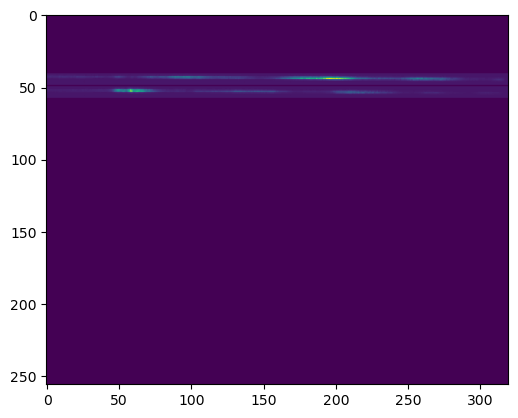

In [19]:
plt.imshow(test_readout)
plt.show()

In [38]:
# 3 spectra

# define test data
D = test_data_123

# extent of detector in x-dir
x_extent = np.shape(simple_profile_1)[1]
y_extent = np.shape(simple_profile_1)[0]

# initialize dict to hold flux for each spectrum
eta = {'1':np.zeros(x_extent),'2':np.zeros(x_extent),'3':np.zeros(x_extent)}

# loop over cols
for col in range(0,x_extent): 
    
    # initialize
    c_11 = 0
    c_12 = 0
    c_13 = 0
    c_22 = 0
    c_23 = 0
    c_33 = 0
    b_1 = 0
    b_2 = 0
    b_3 = 0
    
    # loop over pixels
    for i in range(0,y_extent):
    
        c_11 += simple_profile_1[i,col] * simple_profile_1[i,col] / array_variance[i,col]
        
        c_12 += simple_profile_1[i,col] * simple_profile_2[i,col] / array_variance[i,col]
        
        c_13 += simple_profile_1[i,col] * simple_profile_3[i,col] / array_variance[i,col]
        
        c_22 += simple_profile_2[i,col] * simple_profile_2[i,col] / array_variance[i,col]
        
        c_23 += simple_profile_2[i,col] * simple_profile_3[i,col] / array_variance[i,col]
        
        c_33 += simple_profile_3[i,col] * simple_profile_3[i,col] / array_variance[i,col]
        
        b_1 += D[i,col] * simple_profile_1[i,col] / array_variance[i,col]
        
        b_2 += D[i,col] * simple_profile_2[i,col] / array_variance[i,col]
        
        b_3 += D[i,col] * simple_profile_3[i,col] / array_variance[i,col]
        
    # by symmetry
    c_21 = np.copy(c_12)
    c_31 = np.copy(c_13)
    c_32 = np.copy(c_23)
    
    #print(c_21)
    #print(c_31)
    
    #plt.clf()
    #c_mat_display = np.array([[c_11, c_12, c_13],[c_21, c_22, c_23],[c_31, c_32, c_33]])
    #plt.imshow(c_mat_display, origin='lower')
    #plt.show()
    
    # set off-diagonal vals to zero to make sparse
    '''
    c_21 = 0
    c_12 = 0
    c_13 = 0
    c_31 = 0
    c_23 = 0
    c_32 = 0
    '''
    
    # assemble matrices
    b_mat = np.array([b_1, b_2, b_3])
    c_mat = np.array([[c_11, c_12, c_13],[c_21, c_22, c_23],[c_31, c_32, c_33]])
    
    # solve for the following transform:
    # x * c_mat = b_mat  -->  c_mat.T * x.T = b_mat.T
    eta_mat_T, istop, itn, normr, normar, norma, conda, normx = \
               lsmr(c_mat.transpose(), b_mat.transpose())
    
    eta_mat =  eta_mat_T.transpose()
    
    eta['1'][col] = eta_mat[0]
    eta['2'][col] = eta_mat[1]
    eta['3'][col] = eta_mat[2]
    
    #print(eta_mat)

/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_3116/1088785728.py:30: RuntimeWarning: invalid value encountered in double_scalars
  c_11 += simple_profile_1[i,col] * simple_profile_1[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_3116/1088785728.py:32: RuntimeWarning: invalid value encountered in double_scalars
  c_12 += simple_profile_1[i,col] * simple_profile_2[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_3116/1088785728.py:34: RuntimeWarning: invalid value encountered in double_scalars
  c_13 += simple_profile_1[i,col] * simple_profile_3[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_3116/1088785728.py:36: RuntimeWarning: invalid value encountered in double_scalars
  c_22 += simple_profile_2[i,col] * simple_profile_2[i,col] / array_variance[i,col]
/var/folders/8y/ztvmc5ys1pn64bjywt1qp4k40000gs/T/ipykernel_3116/1088785728.py:38: RuntimeWarning

In [7]:
eta

{'1': array([10386.82789503, 10225.52145461,            nan,            nan,
         9531.56198306, 10428.36017797,  9912.47914705,  9908.38443277,
         9788.37209806, 10609.9223971 ,            nan,            nan,
        10586.6478111 ,  9965.77726372, 10248.51021958, 10228.9361859 ,
         9606.81508781,  9749.4057738 , 10563.39578815, 10400.33109578,
         9778.47323539, 10242.62775948, 10033.2594286 , 10037.48414862,
         9689.6040442 ,  9772.66039783, 10518.64694035, 10115.04049348,
         9585.3217294 ,  9915.34931035,  9546.82749379, 10174.62616694,
         9759.44045238,  9338.84679793,  9331.5806283 ,  9316.747751  ,
         9250.73968104,  9812.45229566,  9505.63080089,  9346.82492214,
         9100.56414657,  9394.8053036 ,  9334.93243847,  9199.67126657,
         9562.44878723,  9293.3595071 ,  9653.01200369, 10236.20721009,
         9454.05833005,  9227.01612166, 10623.15000707, 11165.97284438,
         9195.7560225 ,  9165.48825912,  9508.80504014,  90

In [40]:
from scipy.ndimage import gaussian_filter1d

# smooth

test_smooth1 = gaussian_filter1d(eta['1'],1)
test_smooth2 = gaussian_filter1d(eta['2'],1)
test_smooth3 = gaussian_filter1d(eta['3'],1)

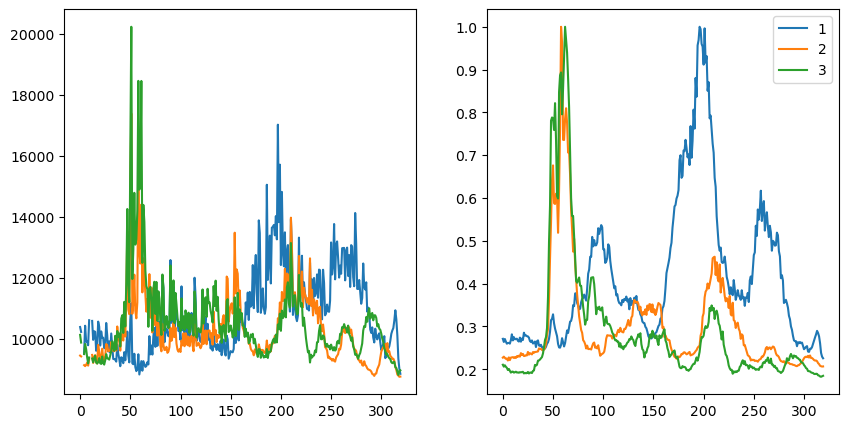

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(eta['1'], label='1')
axs[0].plot(eta['2'], label='2')
axs[0].plot(eta['3'], label='3')
#axs[0].plot(test_smooth1)
#axs[0].plot(test_smooth2)
#axs[0].plot(test_smooth3)


profile_plot_this1 = np.sum(simple_profile_1*test_data_1,axis=0)
profile_plot_this2 = np.sum(simple_profile_2*test_data_12,axis=0)
profile_plot_this3 = np.sum(simple_profile_3*test_data_123,axis=0)
axs[1].plot(np.divide(profile_plot_this1,np.max(profile_plot_this1)), label='1')
axs[1].plot(np.divide(profile_plot_this2,np.max(profile_plot_this2)), label='2')
axs[1].plot(np.divide(profile_plot_this3,np.max(profile_plot_this3)), label='3')

#axs[1].plot(np.sum(test_data_12,axis=0), label='2')
#axs[1].plot(np.sum(test_data_123,axis=0), label='3')

#profile_plot_this2 = np.sum(test_data_1[99:99+t,:],axis=0)
#axs[1].plot(np.divide(profile_plot_this2,np.max(profile_plot_this2))+0.1, label='1')
'''
axs[1].plot(np.sum(test_data_12[155:155+t,:],axis=0), label='2')
axs[1].plot(np.sum(test_data_123[175:175+t,:],axis=0), label='3')
'''
#plt.plot(eta_all_cols, label='1 spec only')
plt.legend()
plt.savefig('junk.png')

In [38]:
profile_plot_this2

4471046.0372857135